## Convert BCI to Behave CSV: BJH017

In [1]:
import pandas as pd
import numpy as np
from scipy import signal, stats
import matplotlib.pyplot as plt
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
from BCI2kReader import BCI2kReader as b2k
import os
import mne
from tabulate import tabulate
import IPython
import seaborn as sns

This script is the interactive/dev version to turn the bci states into a csv comprable to the csvs I get from prolifc in order to compare their behavior.

The basic plan is to create and index to get a timestep of 50ms, loop through all of my_states, pull values for each variable of interest into a csv.

In [2]:
## prep paths

subject = 'BJH017'
orig_data_fi = '/home/brooke/knight_server/remote/WashU/data/PacmanTask/BJH017/PacmanTask/ECOG001/ECOGS001R01.dat'
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}/behave"

In [3]:
with b2k.BCI2kReader(orig_data_fi) as data: #opens a stream to the dat file
    my_signals = data.signals
    my_states = data.states
    my_params = data.parameters

In [4]:
# my_params
# my_states
my_params['ChannelNames'][260]

'DC05'

In [5]:
my_states

{'KeyDown': array([[0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 'KeyUp': array([[0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 'WebcamFrame0': array([[    0,     0,     0, ..., 28043, 28043, 28043]], dtype=int32),
 'WebcamFrame1': array([[0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 'WebcamFrame2': array([[0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 'WebcamFrame3': array([[0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 'EyetrackerTime': array([[   0,    0,    0, ..., 3336, 3336, 3336]], dtype=int32),
 'EyetrackerLeftEyeValidity': array([[0, 0, 0, ..., 4, 4, 4]], dtype=int32),
 'EyetrackerLeftPupilSize': array([[ 0,  0,  0, ..., 47, 47, 47]], dtype=int32),
 'EyetrackerLeftEyeGazeX': array([[    0,     0,     0, ..., 33722, 33722, 33722]], dtype=int32),
 'EyetrackerLeftEyeGazeY': array([[    0,     0,     0, ..., 76466, 76466, 76466]], dtype=int32),
 'EyetrackerLeftEyePosX': array([[    0,     0,     0, ..., 27336, 27336, 27336]], dtype=int32),
 'EyetrackerLeftEyePosY': array([[    0,     0,     0, ..., 60660, 60

In [45]:
my_signals[265, 1:100]

array([32768., 32768., 32768., 32768., 32768., 32768., 32768., 32768.,
       32768., 32768., 32768., 32768., 32768., 32768., 32768., 32768.,
       32768., 32768., 32768., 32768., 32768., 32768., 32768., 32768.,
       32768., 32768., 32768., 32768., 32768., 32768., 32768., 32768.,
       32768., 32768., 32768., 32768., 32768., 32768., 32768., 32768.,
       32768., 32769., 32768., 32768., 32768., 32768., 32768., 32768.,
       32768., 32768., 32768., 32768., 32768., 32768., 32768., 32768.,
       32768., 32768., 32768., 32768., 32768., 32768., 32768., 32768.,
       32768., 32768., 32768., 32768., 32768., 32768., 32768., 32768.,
       32768., 32768., 32768., 32768., 32768., 32768., 32768., 32768.,
       32768., 32768., 32768., 32768., 32768., 32768., 32768., 32768.,
       32768., 32768., 32768., 32768., 32768., 32768., 32768., 32768.,
       32769., 32768., 32768.], dtype=float32)

In [6]:
col_names =  ['Subject',
              'Trial',
              'Sample',
               'Time', 
               'GhostLocation',
               'UserLocation',
               'Direction',
               'Biscuit1',
               'Biscuit2',
               'Biscuit3',
               'Biscuit4',
               'Biscuit5',
               'Attack',
               'Chase',
               'Eaten',
               'Score',
               'Lives',
               'TrialType']

cleaned_game_data = pd.DataFrame(columns = col_names)

In [8]:
samples_per_500 = my_params['SamplingRate'] *.01
task_length = len(my_states['Trial_on_off'][0])
flips_per_task = int(task_length / samples_per_500)



In [12]:
flips_per_task

37392

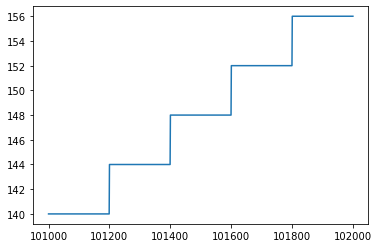

In [47]:
x = 101000
y = 102000

plt.plot(range(x, y), my_states['GhostLocation'][0][x:y])

Okay, so every 50ms, corresponds to a csv with `nrows = 59019`, which is *much* larger than the size of the csvs from prolific data. However, the ITIs in the prolific data are not sampled at 50ms, and the task was run twice for this subject. So together, I think this makes sense 

In [9]:
for iter in range(flips_per_task):
    sample = int(range(task_length)[iter] * samples_per_500)
    cleaned_game_data.loc[iter] = [subject, my_states['Trial_on_off'][0][sample], sample, sample/2000,
              my_states['GhostLocation'][0][sample], my_states['UserLocation'][0][sample], my_states['Direction'][0][sample],  
              my_states['Biscuit1'][0][sample], my_states['Biscuit2'][0][sample], my_states['Biscuit3'][0][sample],
              my_states['Biscuit4'][0][sample], my_states['Biscuit5'][0][sample], my_states['Attack'][0][sample],
              my_states['Chase'][0][sample], my_states['Eaten'][0][sample], my_states['Score'][0][sample],
              my_states['Lives'][0][sample], my_states['TrialType'][0][sample]]


KeyboardInterrupt: 

In [10]:
pd.set_option('display.max_rows', 500)

In [11]:
def find_adjacent_indices(df, col):
    indices  = []
    for i in range(1500, len(df)-3):
        if df[col][i] == df[col][i+1] == df[col][i+2] == df[col][i+3]:
            indices.append(i)
    return(indices)


In [54]:
index_turns = find_adjacent_indices(cleaned_game_data, 'UserLocation')

In [59]:
# index_turns # 1504 is a good test index

In [12]:
def adjust_location_for_blocksize(df_old):
    
    # Create a copy of the original DataFrame to prevent modifying the original data
    df = df_old.copy()
    # Loop through the DataFrame starting from the second row to the second last row
    for i in range(1, len(df) - 1):
        # Skip rows where the player is not moving (Direction is 4)
        if df['Direction'][i] == 4:
            continue
        # Condition 1: Correcting jumps in UserLocation when Direction is constant but the jump is large (over 4 units)
        # Example: UserLocation changes from 90, 90 to 96, 96 (jumps 6 units) while moving in the same Direction
        if df['Direction'][i] == df['Direction'][i-1] and \
            df['UserLocation'][i] = df['UserLocation'][i-1] and \
            df['UserLocation'][i+1] = df['UserLocation'][i+2] and \
            abs(df['UserLocation'][i] - df['UserLocation'][i+1]) > 4:
            if df['Direction'][i] == 11:  # Moving right
                df.loc[i, 'UserLocation'] -= 2
                df.loc[i-1, 'UserLocation'] += 2
            else:  # Moving left
                df.loc[i, 'UserLocation'] += 2
                df.loc[i-1, 'UserLocation'] -= 2
        # Condition 2: Smoothing UserLocation when Direction is constant over three rows
        # Example: UserLocation remains at 90 for two rows but jumps to 94 in the next row
        elif (df['Direction'][i] == df['Direction'][i-1] == df['Direction'][i+1]) and \
             (df['UserLocation'][i] == df['UserLocation'][i-1]) and \
             abs(df['UserLocation'][i] - df['UserLocation'][i-1]) > 2:
            if df['Direction'][i] == 11:  # Moving right
                df.loc[i, 'UserLocation'] += 2
            else:  # Moving left
                df.loc[i, 'UserLocation'] -= 2
        # Condition 3: UserLocation is the same for three consecutive rows, but Direction changes in the next row
        # Example: UserLocation remains 90 for three rows, then jumps to 94 while changing Direction
        elif df['Direction'][i] == df['Direction'][i-1] and \
             df['UserLocation'][i] == df['UserLocation'][i-1] == df['UserLocation'][i+1] and \
             df['Direction'][i] != df['Direction'][i+1] and \
             abs(df['UserLocation'][i] - df['UserLocation'][i+1]) > 2:
            if df['Direction'][i] == 11:  # Moving right
                df.loc[i, 'UserLocation'] += 2
            else:  # Moving left
                df.loc[i, 'UserLocation'] -= 2
        # Condition 4: UserLocation is constant for two rows but changes in the next row, and Direction also changes
        # Example: UserLocation is 90 for two rows, then jumps to 94, with a change in Direction (implying the direction probably changed on the current row)
        elif df['Direction'][i] == df['Direction'][i-1] and \
             df['UserLocation'][i] == df['UserLocation'][i-1] and \
             df['Direction'][i] != df['Direction'][i+1] and \
             abs(df['UserLocation'][i] - df['UserLocation'][i+1]) > 2:
            if df['Direction'][i + 1] == 11:  # Direction changes to right in the next row
                df.loc[i, 'UserLocation'] += 2
                df.loc[i, 'Direction'] = 11
            else:  # Direction changes to left in the next row
                df.loc[i, 'UserLocation'] -= 2
                df.loc[i, 'Direction'] = 2
    return df

In [29]:
tmp = adjust_location_for_blocksize(cleaned_game_data)

In [26]:
tmp[1100:1200]

,Subject,Trial,Sample,Time,GhostLocation,UserLocation,Direction,Biscuit1,Biscuit2,Biscuit3,Biscuit4,Biscuit5,Attack,Chase,Eaten,Score,Lives,TrialType
1140,BJH017,1,114000,57.00,80,53,2,1,1,1,1,0,0,1,4,60,3,5
1141,BJH017,1,114100,57.05,80,51,2,1,1,1,1,0,0,1,4,60,3,5
1142,BJH017,1,114200,57.10,76,49,2,1,1,1,1,0,0,1,4,60,3,5
1143,BJH017,1,114300,57.15,76,49,2,1,1,1,1,0,0,1,4,60,3,5
1144,BJH017,1,114400,57.20,74,47,2,1,1,1,1,0,0,1,4,60,3,5
1145,BJH017,1,114500,57.25,74,45,2,1,1,1,1,0,0,1,4,60,3,5
1146,BJH017,1,114600,57.30,68,41,2,1,1,1,1,0,0,1,4,60,3,5
1147,BJH017,1,114700,57.35,68,39,2,1,1,1,1,0,0,1,4,60,3,5
1148,BJH017,1,114800,57.40,64,37,2,1,1,1,1,0,0,1,4,60,3,5
1149,BJH017,1,114900,57.45,64,35,2,1,1,1,1,0,0,1,4,60,3,5


In [32]:
cleaned_game_data[1200:1400]

,Subject,Trial,Sample,Time,GhostLocation,UserLocation,Direction,Biscuit1,Biscuit2,Biscuit3,Biscuit4,Biscuit5,Attack,Chase,Eaten,Score,Lives,TrialType
1200,BJH017,1,120000,60.00,104,26,4,0,0,0,0,0,0,0,0,60,3,16
1201,BJH017,1,120100,60.05,104,26,4,0,0,0,0,0,0,0,0,60,3,16
1202,BJH017,1,120200,60.10,108,26,4,0,0,0,0,0,0,0,0,60,3,16
1203,BJH017,1,120300,60.15,108,26,4,0,0,0,0,0,0,0,0,60,3,16
1204,BJH017,1,120400,60.20,112,26,4,0,0,0,0,0,0,0,0,60,3,16
1205,BJH017,1,120500,60.25,112,26,4,0,0,0,0,0,0,0,0,60,3,16
1206,BJH017,1,120600,60.30,116,26,4,0,0,0,0,0,0,0,0,60,3,16
1207,BJH017,1,120700,60.35,116,26,4,0,0,0,0,0,0,0,0,60,3,16
1208,BJH017,1,120800,60.40,120,26,4,0,0,0,0,0,0,0,0,60,3,16
1209,BJH017,1,120900,60.45,120,26,4,0,0,0,0,0,0,0,0,60,3,16


In [23]:
cleaned_game_data[(cleaned_game_data['Sample'] > 2672510) & (cleaned_game_data['Sample'] < 2677500)]

,Subject,Trial,Sample,Time,GhostLocation,UserLocation,Direction,Biscuit1,Biscuit2,Biscuit3,Biscuit4,Biscuit5,Attack,Chase,Eaten,Score,Lives,TrialType
26726,BJH017,1,2672600,1336.30,62,100,2,1,1,0,0,0,0,0,2,30,1,11
26727,BJH017,1,2672700,1336.35,62,100,2,1,1,0,0,0,0,0,2,30,1,11
26728,BJH017,1,2672800,1336.40,66,96,2,1,1,1,0,0,0,1,3,50,1,11
26729,BJH017,1,2672900,1336.45,66,96,2,1,1,1,0,0,0,1,3,50,1,11
26730,BJH017,1,2673000,1336.50,70,92,2,1,1,1,0,0,0,1,3,50,1,11
26731,BJH017,1,2673100,1336.55,70,92,2,1,1,1,0,0,0,1,3,50,1,11
26732,BJH017,1,2673200,1336.60,74,88,2,1,1,1,1,0,0,1,4,60,1,11
26733,BJH017,1,2673300,1336.65,74,88,2,1,1,1,1,0,0,1,4,60,1,11
26734,BJH017,1,2673400,1336.70,92,106,11,1,1,1,1,0,0,1,4,60,1,11
26735,BJH017,1,2673500,1336.75,92,106,11,1,1,1,1,0,0,1,4,60,1,11


In [25]:
cleaned_game_data[(cleaned_game_data['Sample'] > 2672510) & (cleaned_game_data['Sample'] < 2677500)]

,Subject,Trial,Sample,Time,GhostLocation,UserLocation,Direction,Biscuit1,Biscuit2,Biscuit3,Biscuit4,Biscuit5,Attack,Chase,Eaten,Score,Lives,TrialType
26726,BJH017,1,2672600,1336.30,62,100,2,1,1,0,0,0,0,0,2,30,1,11
26727,BJH017,1,2672700,1336.35,62,98,2,1,1,0,0,0,0,0,2,30,1,11
26728,BJH017,1,2672800,1336.40,66,96,2,1,1,1,0,0,0,1,3,50,1,11
26729,BJH017,1,2672900,1336.45,66,94,2,1,1,1,0,0,0,1,3,50,1,11
26730,BJH017,1,2673000,1336.50,70,92,2,1,1,1,0,0,0,1,3,50,1,11
26731,BJH017,1,2673100,1336.55,70,90,2,1,1,1,0,0,0,1,3,50,1,11
26732,BJH017,1,2673200,1336.60,74,88,2,1,1,1,1,0,0,1,4,60,1,11
26733,BJH017,1,2673300,1336.65,74,92,11,1,1,1,1,0,0,1,4,60,1,11
26734,BJH017,1,2673400,1336.70,92,104,11,1,1,1,1,0,0,1,4,60,1,11
26735,BJH017,1,2673500,1336.75,92,106,11,1,1,1,1,0,0,1,4,60,1,11


In [24]:
cleaned_game_data = adjust_location_for_blocksize(cleaned_game_data)


In [130]:
# filter to beginning of trial
first_trial = cleaned_game_data.Trial.eq(1).idxmax() - 3 # start a couple of time points ahead of first trial
last_row = cleaned_game_data.shape[0]
cleaned_game_data = cleaned_game_data.loc[first_trial:last_row]

In [131]:
# get trial count
cleaned_game_data.reset_index(inplace=True, drop = True)
last_row = cleaned_game_data.shape[0]
end_index = False
begin_index = False
cleaned_game_data = cleaned_game_data.rename(columns={'Trial': 'Trial_on_off'})  
for idx in range(4, last_row):
    if cleaned_game_data.Trial_on_off[idx] == 0 and cleaned_game_data.Trial_on_off[idx - 1] == 1:
        begin_index = idx + 1
    if cleaned_game_data.Trial_on_off[idx] == 1 and cleaned_game_data.Trial_on_off[idx - 1] == 0:
        end_index = idx - 2
    if end_index is not False:
        bad_df = cleaned_game_data.index.isin(np.arange(begin_index, end_index))
        cleaned_game_data = cleaned_game_data[~bad_df]
        end_index = False
        begin_index = False
        

In [132]:
# so now there are three zeros separating every trial, so lets count the trials!
cleaned_game_data.reset_index(inplace=True, drop = True)
last_row = cleaned_game_data.shape[0]
trial_counter = 1
cleaned_game_data['Trial'] = 0
for idx in range(4, last_row):
    cleaned_game_data.loc[idx, 'Trial'] = trial_counter
    if cleaned_game_data.Trial_on_off[idx] == 0 and cleaned_game_data.Trial_on_off[idx - 1] == 1:
        trial_counter = trial_counter + 1

cleaned_game_data = cleaned_game_data[(cleaned_game_data['Trial'] != trial_counter)] # get rid of trailing zeros

In [133]:
## test 1

cleaned_game_data

,Subject,Trial_on_off,Sample,Time,GhostLocation,UserLocation,Direction,Biscuit1,Biscuit2,Biscuit3,Biscuit4,Biscuit5,Attack,Chase,Eaten,Score,Lives,TrialType,Trial
0,BJH017,0,82500,41.25,66,57,4,0,0,0,0,0,0,0,0,0,3,7,0
1,BJH017,0,82600,41.30,66,57,4,0,0,0,0,0,0,0,0,0,3,7,0
2,BJH017,0,82700,41.35,66,57,4,0,0,0,0,0,0,0,0,0,3,7,0
3,BJH017,1,82800,41.40,66,137,4,0,0,0,0,0,0,0,0,0,3,18,0
4,BJH017,1,82900,41.45,66,137,4,0,0,0,0,0,0,0,0,0,3,18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28299,BJH017,1,3577000,1788.50,90,105,2,1,1,1,1,0,1,0,4,1130,1,9,241
28300,BJH017,1,3577100,1788.55,90,105,2,1,1,1,1,0,1,0,4,1130,1,9,241
28301,BJH017,1,3577200,1788.60,96,105,11,1,1,1,1,0,1,0,4,1070,1,9,241
28302,BJH017,1,3577300,1788.65,96,105,11,1,1,1,1,0,1,0,4,1070,1,9,241


In [1]:
3577200-3577100

100

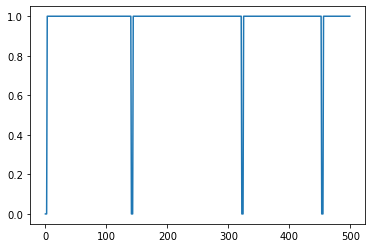

In [134]:
## test 2

plt.plot(range(0, 500), cleaned_game_data['Trial_on_off'][0:500])

In [135]:
## save it

cleaned_game_data.to_csv(f"{raw_data_dir}/{subject}_raw_behave.csv")